<a href="https://colab.research.google.com/github/Psonu2003/QuantumCircuitsSim/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##Task 1: Statevector simulation of quantum circuits

##Author: Pratham Gujar

##Contact: pratham.gujar30@gmail.com




> The code below defines a general GateSimulation class which defines the > essential functions to apply gates, measure runtime and memory, create gates, initializing states, and sample states.







> The GateSVSimulator class inherits the GateSimulation class and defines it's own way of creating gate operations and applying them. It also defines its own function to display states in braket form.





> The GateTensorSimulator class also inherits from the GateSimulation class and has its own similar definitions as the GateSVSimulator—they are just defined slightly different.





> This code accomplishes the simulating and benchmarking both models against runtime and peak memory. The task did only ask for runtime but I included peak memory measurements to provide more breadth in the comparisons. The peak memory was able to find limitations for the tensor simulation based on my hardware environment.



> Beyond this task, this code offers rough projections for both simulations at more qubits. Anyone using this code can also use the defined functions to initialize their own states and perform gate operations similar to IBM Quantum Experience's Quantum Composer (although this code is limited to a few of the several gates).





# Required imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
import random
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator
import re

# Gate Simulator Class

In [184]:
class GateSimulator:
  """
  Defines I, X, H, and CNOT gates and simulates statevector operations
  with matrix multiplication.

  Args:
    n (int): number of qubits
    seed (int or None): seed for random number generator

  Attributes:
    n (int): number of qubits
    seed (int): seed for random number generator
    I (numpy.matrix): Identity matrix
    X (numpy.matrix): Pauli-X matrix
    H (numpy.matrix): Hadamard matrix
    state (str): initial state vector

  Raises:
    TypeError: n must be an integer
    TypeError: seed must be an integer or None
  """
  def __init__(self, n, seed = None):
    if not isinstance(n, int):
      raise TypeError("n must be an integer")
    if not isinstance(seed, (int, type(None))):
      raise TypeError("seed must be an integer")

    self.n = n
    self.seed = seed if seed else np.random.randint(0, 1000000)
    np.random.seed(self.seed)

    # Define basic single-qubit quantum gates
    self.I = np.array([[1, 0],
                      [0, 1]])  # Identity
    self.X = np.array([[0, 1],
                      [1, 0]])  # Pauli-X
    self.H = (1/np.sqrt(2)) * np.array([[1, 1],
                                        [1, -1]])  # Hadamard
    self.Z = np.array([[1, 0],
                      [0, -1]])

    self.Y = np.array([[0, -1j],
                      [1j, 0]])

    self.state = None


  def run_task_with_profiling(self, task, args):
    """
    Measures runtime and memory usage for a given task

    Args:
      task (function): task to be measured

    Returns:
      dict: dictionary containing runtime and memory usage

    Raises:
      TypeError: task must be a function
    """
    if not callable(task):
      raise TypeError("task must be a function")

    tracemalloc.start()

    start_time = time.time()

    result = task(*args)

    end_time = time.time()

    current_memory, peak_memory = tracemalloc.get_traced_memory()

    tracemalloc.stop()

    return {'runtime': end_time - start_time, 'memory': {'current': current_memory, 'peak': peak_memory}, 'result': result}


  def to_bin(self, dec):
    """
    Converts a decimal number to a binary string of length n.

    Args:
      dec (int): decimal number

    Returns:
      str: binary string of length n

    Raises:
      TypeError: dec must be an integer
    """
    if not isinstance(dec, (int, float, np.integer, np.floating)):
      raise TypeError(f"dec {type(dec), dec} must be an integer or float")

    return bin(dec)[2:].zfill(self.n)


  def kronecker_product(self,*args):
    """
    Computes the Kronecker product of a list of matrices.

    Args:
      *args (numpy.matrix or numpy.array): list of matrices

    Returns:
      numpy.matrix: Kronecker product of the matrices

    Raises:
      TypeError: args must be a list of numpy.matrix or numpy.array
    """
    if not all(isinstance(arg, (np.matrix, np.ndarray)) for arg in args):
      raise TypeError("args must be a list of numpy.matrix or numpy.array")

    result = np.array([[1]])
    for arg in args:
        result = np.kron(result, arg)
    return result

  def sample_probability(self):
    """
    Samples probabilities for each state in the register.

    Args:
      None

    Returns:
      None
    """

    args = self.make_operations() # gather args
    self.apply_operations(*args)

    braket = self.state_to_braket()
    amplitudes = np.array(re.findall(r'\((.*?)\)', braket), dtype=float)
    probabilities = np.abs(amplitudes)**2
    kets = re.findall(r'\|.*?\⟩', braket)

    states = np.random.choice(kets, size=1024, p=probabilities/np.sum(probabilities)) # normalize probabilities to mitigate floating-point errors

    _, counts = np.unique(states, return_counts=True)

    title = 'Statevector Probabilities' if self.__class__.__name__ == 'GateSVSimulator' else 'Tensor Probabilities'

    plt.bar(kets, counts/np.sum(counts))
    plt.title(title)
    plt.xlabel('States')
    plt.ylabel('Probability')
    plt.show()

  def initialize_state(self,bitstring, change=False):
      """
      Initializes a state from a given bitstring.
      For example, '01' will give the |01> state.

      Args:
          bitstring (str): string representing qubit register

      Returns:
          numpy.matrix: qubit register state in matrix form

      Raises:
          TypeError: bitstring must be a string (str)
          Exception: bitstring must not contain characters other than '0' and '1'
      """
      if not isinstance(bitstring, str):
          raise TypeError("bitstring must be a string (str)")

      for char in bitstring:
          if char not in ['0', '1']:
              raise Exception("bitstring must not contain characters other than '0' and '1'")

      state = np.matrix((1))  # placeholder to apply first state in for loop

      # Define zero and one states
      zero = np.matrix([1, 0]).T
      one = np.matrix([0, 1]).T

      for bit in bitstring:
          state = np.kron(state, one) if bit == '1' else np.kron(state, zero)

      self.state = state if change else self.state
      return state

  def CX(self, control=1, target=0):
    """
    Creates a CX gate for an n-qubit system with specified control and target.
    Note that this implementation follows little endian notation.

    Args:
      control (int): control qubit
      target (int): target qubit

    Returns:
      numpy.matrix: The matrix representation for the CX gate

    Raises:
      Exception: If c or t is greater than n
    """
    if control >= self.n or target >= self.n:
      raise Exception(f"Control or target is out of bounds for {self.n} qubits")
    elif control == target:
      return self.kronecker_product(*[self.I for _ in range(self.n)])


    # initialize args lists
    zero_args = [self.I for _ in range(self.n)]
    one_args = zero_args.copy()

    # handle control and target with respect to little endian notation
    zero_args[-1 - control] = (self.initialize_state('0') @ self.initialize_state('0').T)

    one_args[-1 - control] = (self.initialize_state('1') @ self.initialize_state('1').T)
    one_args[-1 - target] = self.X


    return self.kronecker_product(*zero_args) + self.kronecker_product(*one_args)


  def calculate_expectation_value(self, gate='X'):
    """
    Calculates the expectation value for a given gate.

    Args:
      gate (str): gate to calculate expectation value for

    Returns:
      float: expectation value for the given gate

    Raises:
      TypeError: gate must be a string (str)
      gatenotfound (Exception): gate not found
    """
    if not isinstance(gate, str):
      raise TypeError("gate must be a string (str)")

    if gate not in ['X', 'H', 'I', 'Y', 'Z']:
      raise Exception("gate not found")

    if gate == 'X':
      Gate = self.X
    elif gate == 'H':
      Gate = self.H
    elif gate == 'Y':
      Gate = self.Y
    elif gate == 'Z':
      Gate = self.Z
    else:
      Gate = self.I

    state = np.matrix(self.state.flatten())
    Gate_n = self.kronecker_product(*[Gate for _ in range(self.n)])

    return np.real(state @ Gate_n @ state.T).item()


  def make_operations(self):
    raise NotImplementedError("Subclasses must implement this method")

  def apply_operations(self, *args):
    raise NotImplementedError("Subclasses must implement this method")

  def state_to_braket(self):
    raise NotImplementedError("Subclasses must implement this method")




# Gate Statevector Simulator Class

In [185]:
class GateSVSimulator(GateSimulator):
  """
  Defines I, X, H, and CNOT gates and simulates statevector operations
  with matrix multiplication.

  Args:
    n (int): number of qubits
    seed (int or None): seed for random number generator
    state (str): initial state vector

  Attributes:
    n (int): number of qubits
    seed (int): seed for random number generator
    I (numpy.matrix): Identity matrix
    X (numpy.matrix): Pauli-X matrix
    H (numpy.matrix): Hadamard matrix
    state (str): initial state vector

  Raises:
    TypeError: n must be an integer
    TypeError: seed must be an integer or None
    TypeError: state must be a string (str)
  """

  def __init__(self, n, state = None, seed = None):
    super().__init__(n, seed)

    if not isinstance(state, (str, type(None))):
      raise TypeError("state must be a string (str)")

    bitstring = ''.join(np.random.choice(['0', '1'], size=n))
    self.state = self.initialize_state(state, change=True) if state else self.initialize_state(bitstring, change=True)

  def state_to_braket(self):
    """
    Converts a state vector to bra-ket notation.

    Args:
      state (numpy.matrix or numpy.array): state vector

    Returns:
      str: bra-ket notation of the state
    """
    braket = ''
    dec = np.where(self.state != 0)[0]

    for i, d in enumerate(dec):
      amplitude = self.state[d].item() if self.state[d].item() > 1e-10 else 0 # check if amplitude is greater than 0
      if amplitude:
        if braket:
          braket += f" {'+' if amplitude > 0 else '-'} ({abs(amplitude):.3f})|{self.to_bin(d)}⟩"
        else:
          braket += f"({abs(amplitude):.3f})|{self.to_bin(d)}⟩"
    return braket


  def make_operations(self):
    """
    Processes and precalculates necessary operations before applying and measuring runtime

    Args:
      None

    Returns:
      operations_list (list): list of operations to be applied
      CX (numpy.matrix): CX gate
    """
    operations_list = []
    if self.n < 2:
      return self.H, self.I

    num_of_H = self.n // 2
    num_of_X = self.n // 2

    for _ in range(num_of_H):
      operations_list.append(self.H)

    for _ in range(num_of_X):
      operations_list.append(self.X)

    # handles odd number of total qubits
    if len(operations_list) < self.n:
      operations_list.append(self.I)

    operations = self.kronecker_product(*operations_list)

    # creates a CX gate with random control and target
    control = np.random.randint(0, self.n)
    target = np.random.randint(0, self.n)
    while target == control:
      target = np.random.randint(0, self.n)


    return operations, self.CX(control, target)

  def apply_operations(self, operations, CX):
    """
    Applies operations to the state vector

    Args:
      operations (numpy.matrix): operations to be applied
      CX (numpy.matrix): CX gate
    """
    self.state = CX @ operations @ self.state


# Gate Tensor Simulator Class

In [186]:
class GateTensorSimulator(GateSimulator):
  """
  Defines I, X, H, and CNOT gates and simulates tensor operations
  with tensor multiplication.

  Args:
    n (int): number of qubits
    seed (int or None): seed for random number generator
    state (str): initial state vector

  Attributes:
    n (int): number of qubits
    seed (int): seed for random number generator
    I (numpy.matrix): Identity matrix
    X (numpy.matrix): Pauli-X matrix
    H (numpy.matrix): Hadamard matrix

  Raises:
    TypeError: n must be an integer
    TypeError: seed must be an integer or None
    TypeError: state must be a string (str)
  """

  def __init__(self, n, state = None, seed = None):
    super().__init__(n, seed)
    if not isinstance(state, (str, type(None))):
      raise TypeError("state must be a string (str)")

    self.state = np.zeros([2 for i in range(n)])
    bitstring = state if state else ''.join(np.random.choice(['0', '1'], size=n))
    self.state[tuple(int(bit) for bit in bitstring)] = 1

  def state_to_braket(self):
    """
    Converts a state vector to bra-ket notation.

    Args:
      state (numpy.matrix or numpy.array): state vector

    Returns:
      str: bra-ket notation of the state

    Raises:
      TypeError: state must be a numpy.matrix or numpy.array
    """
    if not isinstance(self.state, (np.matrix, np.ndarray)):
      raise TypeError("state must be a numpy.matrix or numpy.array")

    bin_states = list(zip(*np.where(self.state > 0))) # gathers all activated states
    braket = ''
    for q in bin_states:
      amplitude = self.state[q]

      # checks if amplitude is above zero
      if amplitude > 1e-10:
        binary_state = ''.join(map(str, q))
        if braket:
          braket += f" {'+' if amplitude > 0 else '-'} ({abs(amplitude):.3f})|{binary_state}⟩"
        else:
          braket += f"({abs(amplitude):.3f})|{binary_state}⟩"

    return braket


  def make_operations(self):
    """
    Processes and precalculates necessary operations before applying and measuring runtime

    Args:
      None

    Returns:
      operations_list (list): list of operations to be applied
      CX (numpy.matrix): CX gate
      qubits_ein (str): string representing qubits in little endian notation
    """
    operations_list = []
    qubits_ein = ''.join([chr(ord('b') + i) for i in range(self.n)]) # creates einsum input string for qubits

    if self.n < 2:
      return [(self.H, 'ab', 'a')], self.I, qubits_ein

    num_of_H = self.n // 2
    num_of_X = self.n // 2

    for i in range(num_of_H):
      ein_inp = 'a' + qubits_ein[i] # creates einsum input string for gate
      ein_out = qubits_ein.replace(ein_inp[-1], ein_inp[0]) # creates einsum output string
      operations_list.append((self.H, ein_inp, ein_out))

    for i in range(num_of_X):
      ein_inp = 'a' + qubits_ein[i + num_of_H]
      ein_out = qubits_ein.replace(ein_inp[-1], ein_inp[0])
      operations_list.append((self.X, ein_inp, ein_out))

    # creates a CX gate with random control and target
    control = np.random.randint(0, self.n)
    target = np.random.randint(0, self.n)
    while target == control:
      target = np.random.randint(0, self.n)

    # reverse operations to match SV model
    operations_list.reverse()

    return operations_list, self.CX(control, target), qubits_ein

  def apply_operations(self, operations, CX, qubits_ein):
    """
    Applies operations to the state vector

    Args:
      operations (list): list of operations to be applied
      CX (numpy.matrix): CX gate
      qubits_ein (str): string representing qubits in little endian notation
    """
    # apply operations to state vector
    for gate, ein_inp, ein_out in operations:
      self.state = np.einsum(f'{ein_inp}, {qubits_ein} -> {ein_out}', gate, self.state)

    # apply CX gate to flattened tensor state
    self.state = np.array(CX @ self.state.flatten())
    self.state = self.state.reshape([2 for i in range(self.n)])


# Simulation Function

In [5]:
def simulate(GateSim, max_qubits=10):
  """
  Simulates gate operations on a qubit register's state based on the
  simulation model.

  Args:
    GateSimulator (class): gate simulation model
    max_qubits (int): maximum qubits to simulate

  Returns:
    runtimes (numpy.array): runtimes for each number of qubits
    peak_memory (numpy.array): peak memory usage for each number of qubits

  Raises:
    Exception: GateSimulator must be a valid GateSimulator (GateSVSimulator or GateTensorSimulator)
  """
  data = []
  for n in range(1, max_qubits + 1):
    Sim = GateSim(n)

    if GateSim == GateSVSimulator:
      args = Sim.make_operations()
      title = 'Statevector Simulator'

    elif GateSim == GateTensorSimulator:
      args = Sim.make_operations()
      title = 'Tensor Simulator'

    else:
      raise Exception("GateSimulator must be a valid GateSimulator (GateSVSimulator or GateTensorSimulator)")


    data.append(Sim.run_task_with_profiling(Sim.apply_operations, args))

  fig, ax = plt.subplots(2,1, figsize=(13,8), sharex=True)

  runtimes = np.array([d['runtime'] for d in data])
  peak_memory = np.array([d['memory']['peak'] for d in data])/(1024**2)
  qubits = range(1, len(data) + 1)

  ax[0].plot(qubits, runtimes, 'o-')
  ax[0].set_title('Runtime')
  ax[0].set_xlabel('Number of qubits')
  ax[0].set_ylabel('Time (s)')
  ax[0].grid(axis='y')
  ax[0].xaxis.set_tick_params(labelbottom=True)


  # Creating the bar plot for peak memory usage
  ax[1].bar(qubits, peak_memory, width=0.5, color='royalblue')
  ax[1].set_title('Peak Memory Usage Across Runs')
  ax[1].set_xlabel('Number of Qubits')
  ax[1].set_ylabel('Memory Usage (MB)')
  ax[1].set_xticks(qubits)
  ax[1].set_xticklabels(qubits)
  ax[1].grid(axis='y')

  fig.suptitle(title)

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()

  return runtimes, peak_memory

# Simulation

For the **statevector** simulation, the limits is 13 qubits on Google Colab for a reasonable time of completion. After that, the timescale is around $10^3$ for 14 qubits (as shown in the projection data).

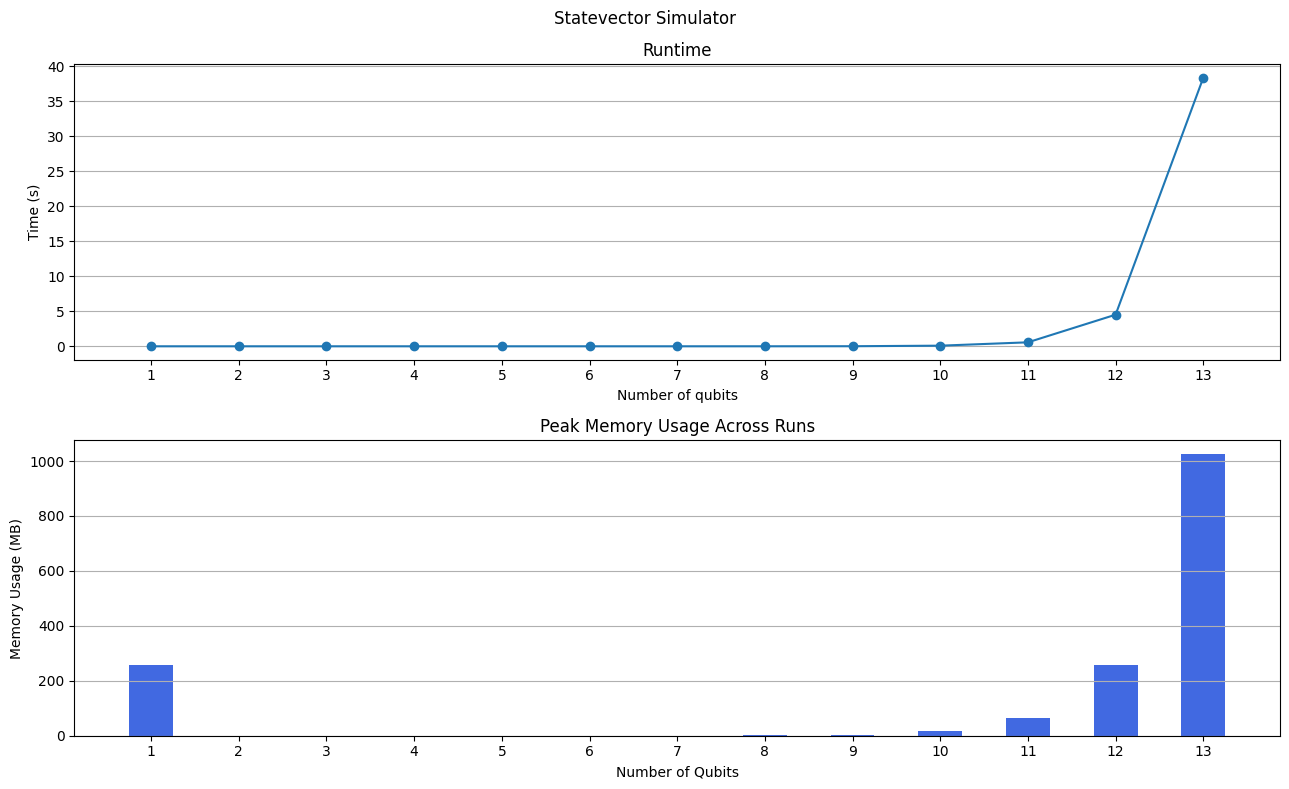

In [43]:
runtimes_matrix, peak_memory_matrix = simulate(GateSVSimulator, max_qubits=13)

The **tensor** simulation limit is 14 qubits on Google Colab because of the memory limitation. At 15 qubits, the memory exceeds the 12.7 GB of ram and crashes the notebook. Though, we see that the timescale is significantly smaller than the statevector simulation with 14 qubits being at around 1 second. The tensor projection data suggests we can simulate around 18 qubits in the time it takes the statevector model to simulate 14.

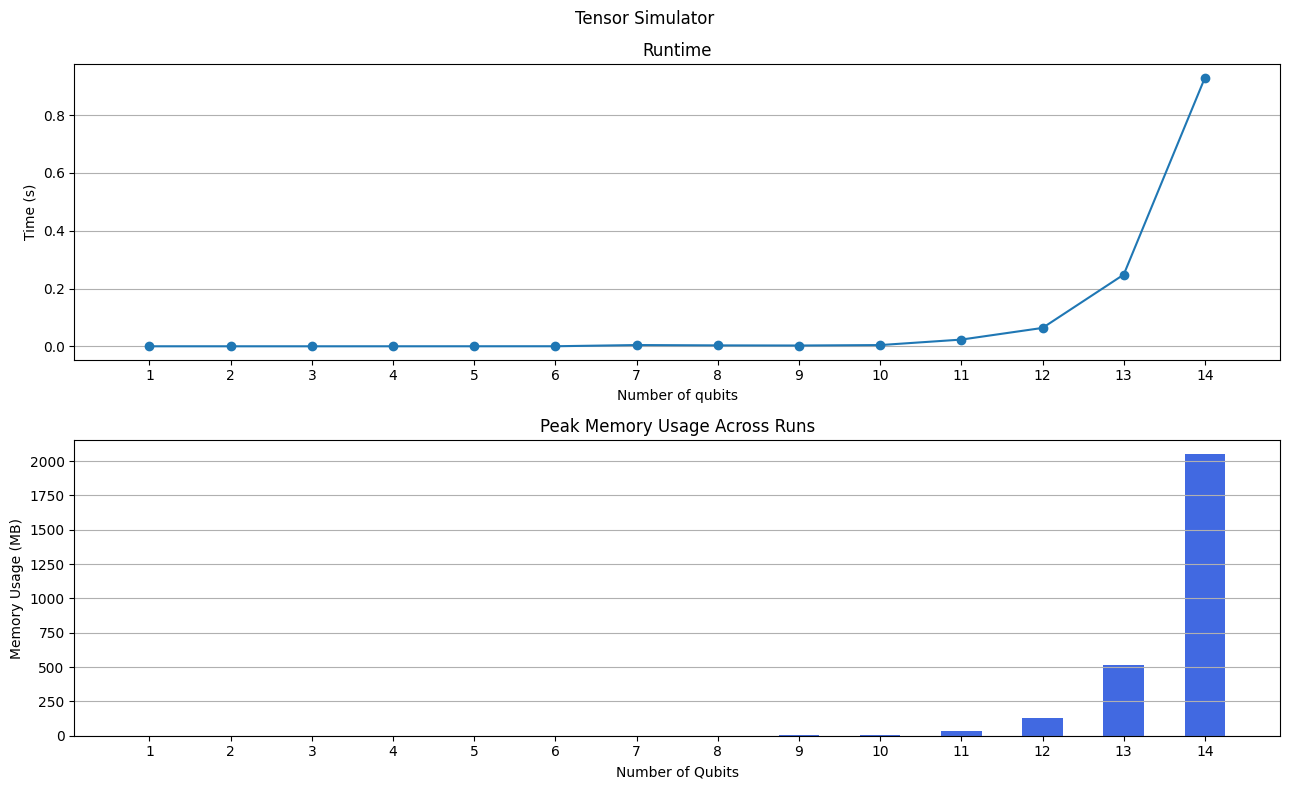

In [192]:
runtimes_tensor, peak_memory_tensor = simulate(GateTensorSimulator, max_qubits=14)

# Projection based on data

Note that this projection is not very accurate on a small scale but is meant to show the rate of magnitude change in the timescale per additional qubit. We see an exponential increase $\propto 2^n$ for $n$ qubits.

In [45]:
def exponential_func(x, a, b):
    return a * np.power(2,b * x)

def projection_data(runtimes, peak_memory, title = None):
  x_data = range(len(runtimes))

  # Fit the exponential model for runtime
  params_runtime, _ = curve_fit(exponential_func, x_data, runtimes, p0=[0,0])

  # Fit the exponential model for peak memory
  params_memory, _ = curve_fit(exponential_func, x_data, peak_memory)


  # Generate new x values for projections
  x_projection = np.linspace(0, len(runtimes) + 5, 100)  # Extend range for projection
  y_runtime_projection = exponential_func(x_projection, *params_runtime)
  y_memory_projection = exponential_func(x_projection, *params_memory)

  fig, ax = plt.subplots(2,1, figsize=(13,8))

  # Plotting the data points
  ax[0].plot(x_projection, y_runtime_projection, '--', label='Data Points', color='royalblue')
  ax[0].set_title('Projected Runtime')
  ax[0].set_xlabel('Number of qubits')
  ax[0].set_ylabel('Time (s)')
  ax[0].grid(axis='y')
  ax[0].set_yscale('log')
  ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

  a, b= params_runtime
  equation_text = rf"Runtime Fit: $y = {a:.3e} \cdot 2^{{ {b:.3f} x }}$"
  ax[0].text(max(x_projection) * 0.25, max(y_runtime_projection) * 0.02, equation_text, fontsize=12, ha='center', color='black')

  ax[1].plot(x_projection, y_memory_projection, '--', label='Data Points', color='royalblue')
  ax[1].set_title('Projected Peak Memory Usage')
  ax[1].set_xlabel('Number of qubits')
  ax[1].set_ylabel('Memory Usage (MB)')
  ax[1].grid(axis='y')
  ax[1].set_yscale('log')
  ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

  a, b= params_memory
  equation_text = rf"Peak Memory Fit: $y = {a:.3f} \cdot 2^{{ {b:.3f} x }}$"
  ax[1].text(max(x_projection) * 0.25, max(y_memory_projection) * 0.02, equation_text, fontsize=12, ha='center', color='black')

  if title:
    fig.suptitle(title)

  # Adjust layout to prevent overlap
  plt.tight_layout()
  plt.show()


# Statevector Projection

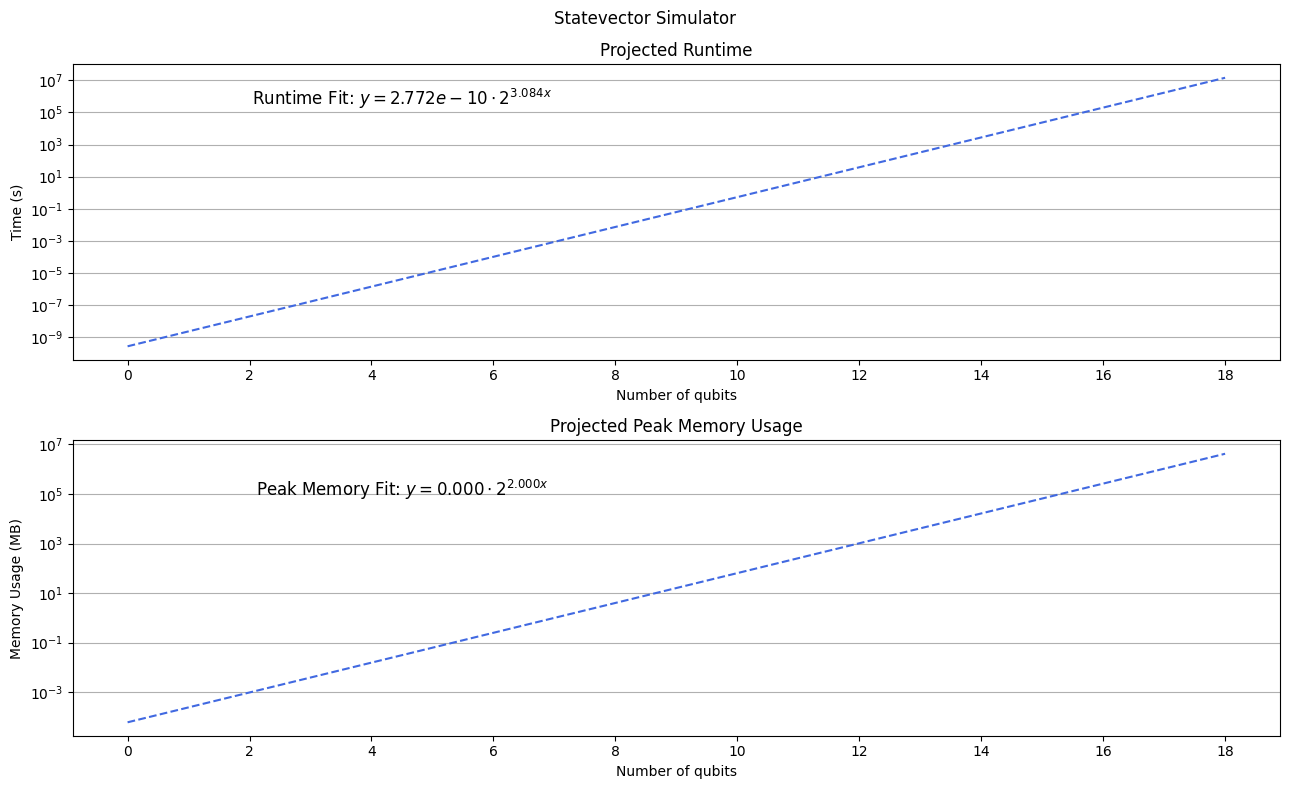

In [47]:
projection_data(runtimes_matrix, peak_memory_matrix, title = 'Statevector Simulator')

# Tensor Projection

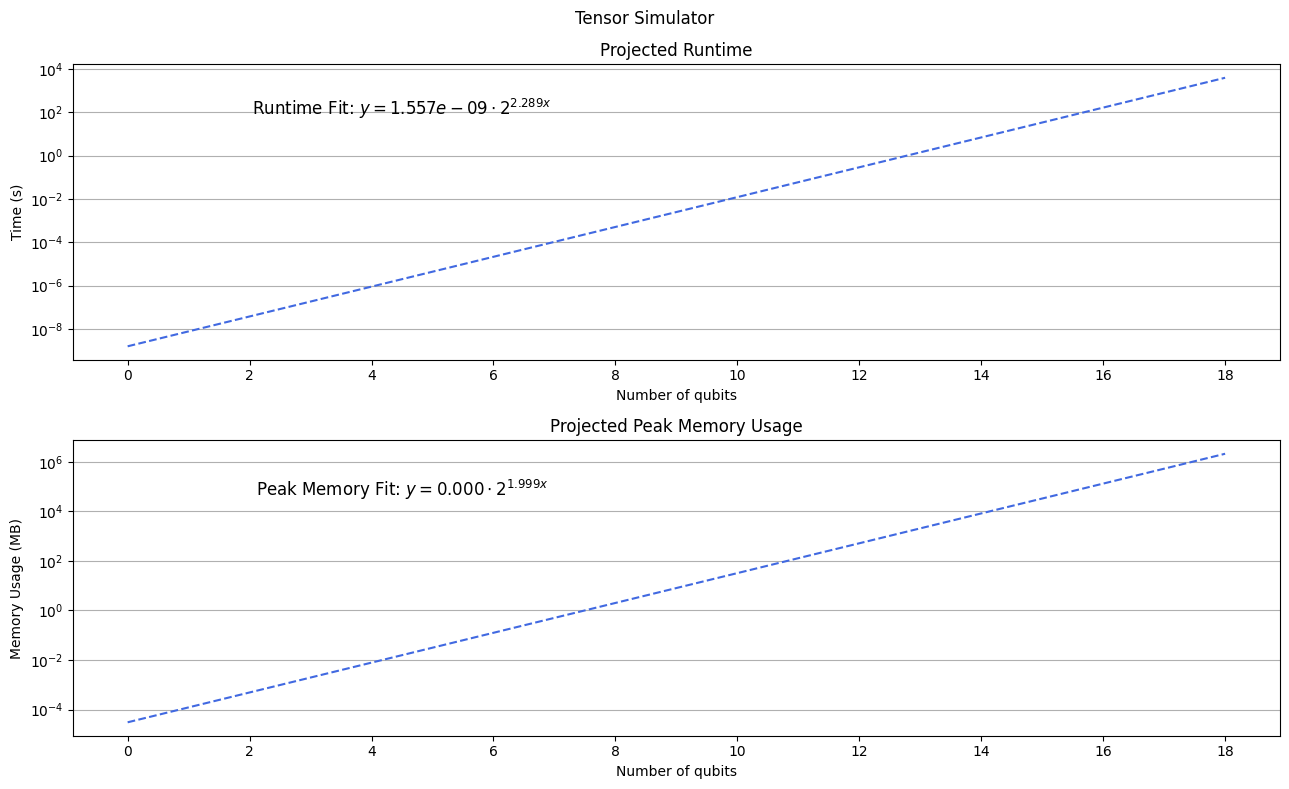

In [48]:
projection_data(runtimes_tensor, peak_memory_tensor, title = 'Tensor Simulator')

# Sample Final States and Expectation Values

**Statevector**

Here, we can sample the probability by using Born's rule, indicating that the probability of a state is it's amplitude absolute squared. If $Ψ = α|0⟩ + β|1⟩$ is the state, then $P(|0⟩) = α^2$ and $P(|1⟩) = β^2$ give the probabilities of |0⟩ and |1⟩. In the 'sample_probability' function in 'GateSimulator', you can see how I use the braket notation to gather the amplitude and states to find calculate the probabilities. Using 'np.random.choice', I could randomly sample from the states based on each state's probability weight.

The expectation value is given by $⟨Ψ|O_P|Ψ⟩$ where the observable is usually $\mathbf{X}$, $\mathbf{Z}$, or $\mathbf{Y}$. This portion is straightforward as numpy directly supports this type of computation.

Initial State: (1.000)|0000⟩


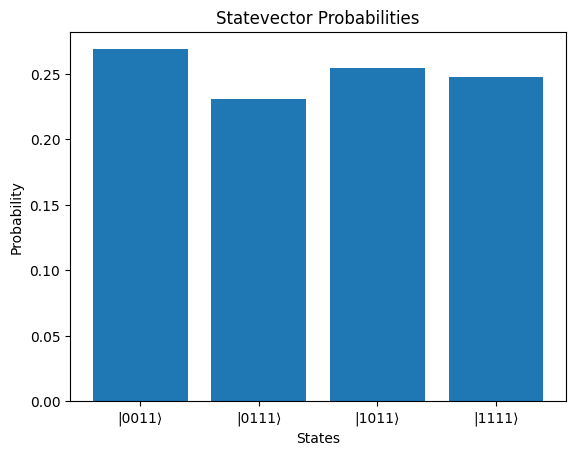

Expectation Value for ⟨Ψ|H|Ψ⟩: 0.2499999999999998


In [190]:
SV_Sim = GateSVSimulator(n=4, state='0000', seed=42)
print('Initial State:', SV_Sim.state_to_braket())

SV_Sim.sample_probability()

gate = 'X'

print(f'Expectation Value for ⟨Ψ|{gate}|Ψ⟩:', SV_Sim.calculate_expectation_value(gate))

**Tensor**

Initial State: (1.000)|0000⟩


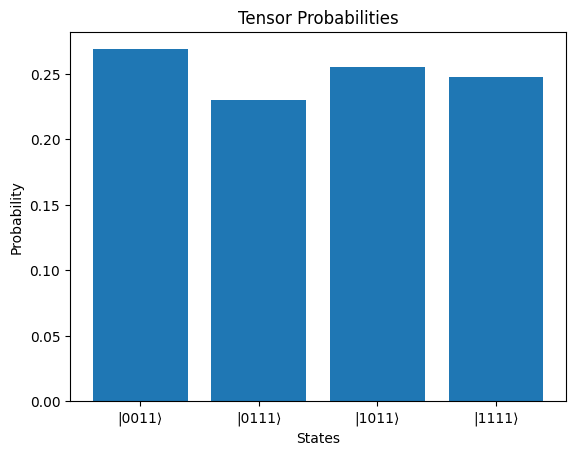

Expectation Value for ⟨Ψ|X|Ψ⟩: 0.0


In [191]:
Tensor_Sim = GateTensorSimulator(n=4, state='0000', seed=42)
print('Initial State:', Tensor_Sim.state_to_braket())

Tensor_Sim.sample_probability()

gate = 'X'

print(f'Expectation Value for ⟨Ψ|{gate}|Ψ⟩:', Tensor_Sim.calculate_expectation_value(gate))